# Adding exponential mass loss/growth

You can always modify the mass of particles between calls to `sim.integrate`.  However, if you want to apply the mass/loss growth every timestep *within* calls to `sim.integrate`, you should use this.

We begin by setting up a system with 3 planets.

In [1]:
import rebound
import reboundx
import numpy as np
sim = rebound.Simulation()
sim.G = 4*np.pi**2 # use units of AU, yrs and solar masses

M0 = 1. # initial mass of star
sim.add(m=M0)
sim.add(a=1.)
sim.add(a=2.)
sim.add(a=3.)
sim.move_to_com()
ps = sim.particles

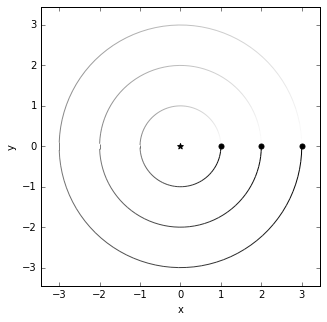

In [2]:
%matplotlib inline
fig = rebound.OrbitPlot(sim)

We now add mass loss through REBOUNDx:

In [3]:
rebx = reboundx.Extras(sim)
mass_effect = rebx.add("modify_mass")

Now we set the e-folding mass loss/growth rate.  

**Positive timescales give growth, negative timescales loss.**

Here we have the star lose mass with an e-folding timescale of $10^4$ yrs.

In [4]:
ps[0].params["tau_mass"] = -1.e4

Now we integrate for one e-folding timescale, and plot the resulting system:

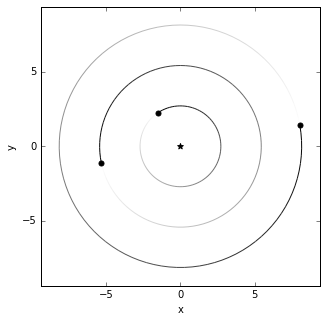

In [5]:
Nout = 1000
mass = np.zeros(Nout)
times = np.linspace(0., 1.e4, Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    mass[i] = sim.particles[0].m
    
fig = rebound.OrbitPlot(sim, trails=True)

We see that after the mass of the star has decayed by a factor of `e`, the scale of the system has expanded by the corresponding factor, as one would expect.  If we plot the mass of the star vs time, compared to an exponential decay, the two overlap.

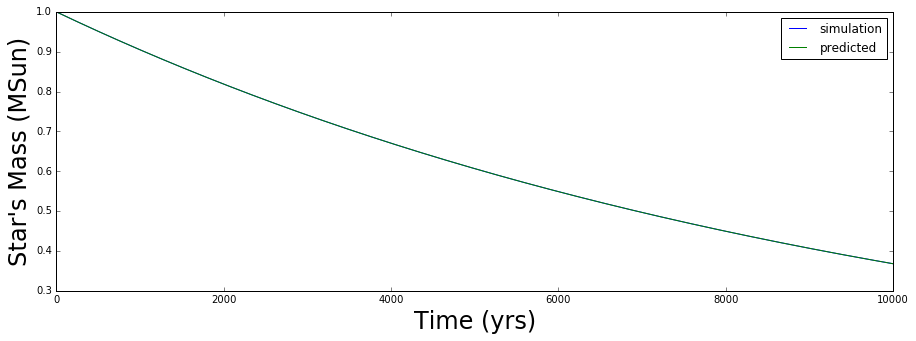

In [6]:
pred = M0*np.e**(times/ps[0].params["tau_mass"])
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.plot(times,mass, label='simulation')
ax.plot(times,pred, label='predicted')
ax.set_xlabel("Time (yrs)", fontsize=24)
ax.set_ylabel("Star's Mass (MSun)", fontsize=24)
plt.legend()